In [1]:
%matplotlib inline
import numpy as np
import struct
import matplotlib.pyplot as plt

# 載入資料集

In [2]:
# 資料集位置
path = 'Data/'

In [3]:
# 讀檔
def get_image(path):
    x_train = []
    y_train = []
    x_test = []
    y_test = []
    
    # read ytrain
    file = open(path + 'train-labels.idx1-ubyte','rb')
    buffer = file.read() 
    header = struct.unpack_from('>II' , buffer ,0)
    num_data = header[1]
    offset = struct.calcsize('>II') #兩個int的大小
    numString='>'+str(num_data)+"B"
    y_train= struct.unpack_from(numString , buffer , offset)
    
    # read xtrain
    file = open(path + 'train-images.idx3-ubyte','rb')
    buffer = file.read() 
    for i in range(num_data):
        image_index = i * struct.calcsize('784B') #28x28=768個pixels,每個用1bytes
        image_index += struct.calcsize('>IIII')
        x_train.append(struct.unpack_from('784B', buffer, image_index))
    
    # read ytest
    file = open(path + 't10k-labels.idx1-ubyte','rb')
    buffer = file.read() 
    header = struct.unpack_from('>II' , buffer ,0)
    num_data = header[1]
    offset = struct.calcsize('>II')
    numString='>'+str(num_data)+"B"
    y_test= struct.unpack_from(numString , buffer , offset)
    
    # read xtest
    file = open(path + 't10k-images.idx3-ubyte','rb')
    buffer = file.read() 
    for i in range(num_data):
        image_index = i * struct.calcsize('784B')
        image_index += struct.calcsize('>IIII')
        x_test.append(struct.unpack_from('784B', buffer, image_index))
    
    return np.array(x_train), np.array(x_test), np.array(y_train), np.array(y_test)

In [4]:
# 給予一維陣列,畫出相對應圖形,以及答案
def draw_image(x,y):
    im = np.reshape(x,(28,28))
    plt.title(y)
    plt.imshow(im , cmap='gray')
    plt.show()

In [5]:
X_train, X_test, y_train, y_test = get_image('Data/')

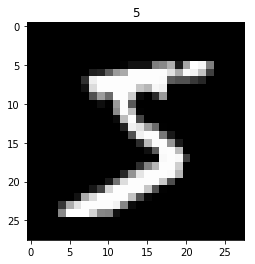

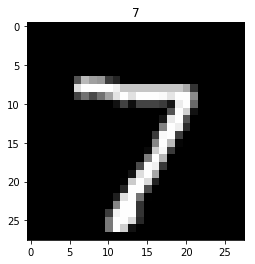

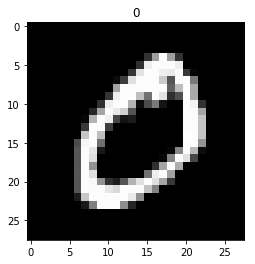

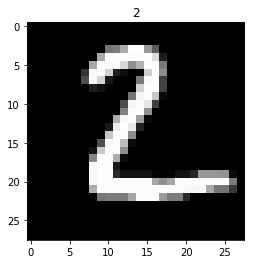

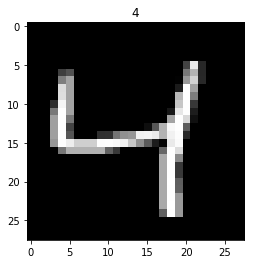

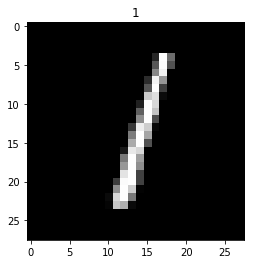

In [6]:
for i in range(3):
    draw_image(X_train[i],y_train[i])
    draw_image(X_test[i],y_test[i])

# one hot encoder 

In [7]:
import pandas as pd
y_train = np.array(pd.get_dummies(y_train))
y_test = np.array(pd.get_dummies(y_test))

# 切分驗證資料集

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size = 0.2, random_state=100)

In [9]:
# 觀察內容狀況
print(X_train.shape, y_train.shape)
print(X_valid.shape, y_valid.shape)
print(X_test.shape, y_test.shape)

(48000, 784) (48000, 10)
(12000, 784) (12000, 10)
(10000, 784) (10000, 10)


# 建立graph

In [10]:
import tensorflow as tf

In [11]:
tf.reset_default_graph() ## 將graph reset,重新 build graph 需要跑這行

In [12]:
# parameter
epochs = 10
batch_size = 100
lr = 0.001

In [13]:
# ------------------------------------graph-----------------------------------------
tf.reset_default_graph() # clean graph
# Declare the input node
with tf.name_scope('input'):
    x_input = tf.placeholder(shape = (None,X_train.shape[1]), 
                             name = 'x_input',
                             dtype=tf.float32)
    y_out = tf.placeholder(shape = (None, y_train.shape[1]), 
                           name = 'y_label',
                           dtype=tf.float32)

# --------------------Declare the network structure----------------------------
"""---------與上面不一樣的地方(將一個layer的所有程式用一個內建function取代)----------"""
with tf.variable_scope('hidden_layer'):
    x_h1 = tf.layers.dense(inputs= x_input, units= 25, activation=tf.nn.relu)


with tf.variable_scope('output_layer'):
    output = tf.layers.dense(x_h1, 10)
'''---------------------------------------------------------------------------'''
with tf.name_scope('cross_entropy'):
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=output, labels=y_out))
    
with tf.name_scope('accuracy'):
    correct_prediction = tf.equal(tf.argmax(tf.nn.softmax(output),1), tf.argmax(y_out,1))
    compute_acc = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

with tf.name_scope('train'):
    train_step = tf.train.AdamOptimizer(learning_rate=lr).minimize(loss)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.



# 訓練加測試資料

100%|██████████| 10/10 [00:12<00:00,  1.23s/it]


--- training done ---
testing accuracy: 0.90


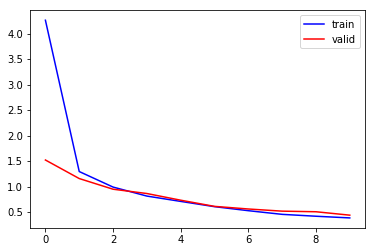

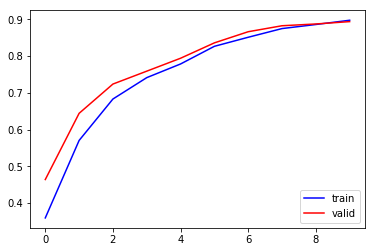

In [14]:
from tqdm import tqdm # 時間條
from sklearn.utils import shuffle # 亂樹
train_loss_list, valid_loss_list = [], []
train_acc_list, valid_acc_list = [], []
#--------------------------------------sess--------------------------------------------
with tf.Session() as sess:
    # we have to initalize all variables (e.g. weights/biases) at the begin
    sess.run([tf.global_variables_initializer()])
    
    for i in tqdm(range(epochs)):
        # get batch 
        total_batch = int(np.floor(len(X_train) / batch_size)) # just drop out last few samples...
        
        train_loss_collector, train_acc_collector = [], []
        for j in np.arange(total_batch):
            batch_idx_start = j * batch_size
            batch_idx_stop = (j+1) * batch_size

            x_batch = X_train[batch_idx_start : batch_idx_stop]
            y_batch = y_train[batch_idx_start : batch_idx_stop]
            
            this_loss, this_acc, _ = sess.run([loss, compute_acc,train_step],
                                    feed_dict = {x_input: x_batch,
                                                 y_out: y_batch})
            train_loss_collector.append(this_loss)
            train_acc_collector.append(this_acc)
            
        # do validation at the end of each epoch
        valid_acc, valid_loss = sess.run([compute_acc, loss],
                                         feed_dict = {x_input: X_valid,
                                                      y_out : y_valid})
        valid_loss_list.append(valid_loss)
        valid_acc_list.append(valid_acc)
        train_loss_list.append(np.mean(train_loss_collector))
        train_acc_list.append(np.mean(train_acc_collector))

        # at the end of each epoch, shuffle the data
        X_train, y_train = shuffle(X_train, y_train)
    # At the end of the training, do testing set
    test_acc, test_loss = sess.run([compute_acc, loss],
                                    feed_dict = {x_input: X_test,
                                                 y_out : y_test})
print('--- training done ---')
print('testing accuracy: %.2f' % test_acc)
#--------------------------------------plot---------------------------------------------
plt.plot(np.arange(len(train_loss_list)), train_loss_list, 'b', label = 'train')
plt.plot(np.arange(len(valid_loss_list)), valid_loss_list, 'r', label = 'valid')
plt.legend()
plt.show()

plt.plot(np.arange(len(train_acc_list)), train_acc_list, 'b', label = 'train')
plt.plot(np.arange(len(valid_acc_list)), valid_acc_list, 'r', label = 'valid')
plt.legend(loc = 4)
plt.show()